```{toggle} env vars and jax debug config notes
❇️ Magic & debug not currently used

%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES='3'
%env "WANDB_NOTEBOOK_NAME" "run.ipynb" # ❕same as notebook

from jax.config import config
config.update('jax_disable_jit', True)
```

In [2]:
### fancy logging variables, philosophically reminding us of the goal ###
fancy = dict(
		pe		= r'$V(X)',    				
		ke		= r'$\nabla^2',    		
		e		= r'$E',						
		log_psi	= r'$\log\psi', 			
		deltar	= r'$\delta_\mathrm{r}',	
		x		= r'$r_\mathrm{e}',
)

### pyfig ###
from pyfig import Pyfig

args = {
	'l_e':[4,], 
	'a_z':[4,], 
	'n_u': 2,
	'n_b': 512, 
	'n_sv': 32, 
	'n_pv': 32, 
	'corr_len': 10, 
	'n_step': 100000, 
	'log_metric_step': 50, 
	'exp_name':'junk'
}

c = Pyfig(wandb_mode='online', args=args, get_sys_arg=False)

### istribution ✨ jit ❇ Demo 💪 ### 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
n_device = c.n_device
print(f'🤖 {n_device} GPUs available')


### model (aka TrainState) ### 
from functools import partial
import jax
import optax
from flax.training.train_state import TrainState
from hwat import FermiNet

@partial(jax.pmap, axis_name='dev', in_axes=(0,0))
def create_train_state(rng, r):
	model = c.partial(FermiNet)
	params = model.init(rng, r)
	opt = optax.chain(optax.clip_by_block_rms(1.),optax.adamw(0.001))
	return TrainState.create(apply_fn=model.apply, params=params, tx=opt)


### train step ###
from jax import numpy as jnp
from hwat import compute_ke_b, compute_pe_b

@partial(jax.pmap, in_axes=(0, 0))
def train_step(state, r_step):
	class v:
		...

	v.ke = compute_ke_b(state, r_step)
	v.pe = compute_pe_b(r_step, c.data.a, c.data.a_z)
	v.e = v.pe + v.ke
	
	e_mean_dist = jnp.mean(jnp.abs(jnp.median(v.e) - v.e))
	e_clip = jnp.clip(v.e, a_min=v.e-5*e_mean_dist, a_max=v.e+5*e_mean_dist)

	def loss(params):
		return ((e_clip - e_clip.mean())*state.apply_fn(params, r_step)).mean()
	
	grads = jax.grad(loss)(state.params)
	state = state.apply_gradients(grads=grads)
	return state, v


### init variables ###
from utils import gen_rng
from hwat import init_r, get_center_points
from jax import random as rnd

rng, rng_p = gen_rng(rnd.PRNGKey(c.seed), c.n_device)
center_points = get_center_points(c.data.n_e, c.data.a)
r = init_r(rng_p, c.data.n_b, c.data.n_e, center_points, std=0.1)


### init functions ### 
from hwat import sample_b

state = create_train_state(rng_p, r)
metro_hast = jax.pmap(partial(sample_b, corr_len=c.data.corr_len), in_axes=(0,0,0,0))


### train ###
import wandb
from hwat import keep_around_points
from utils import compute_metrix

wandb.define_metric("*", step_metric="tr/step")
for step in range(1, c.n_step+1):
	rng, rng_p = gen_rng(rng, c.n_device)

	r, acc, deltar = metro_hast(rng_p, state, r, deltar)
	
	r = keep_around_points(r, center_points, 5.) if step < 1000 else r
	
	state, v_train = train_step(state, r)

	if not (step % c.log_metric_step):
		# data = v_train.d, v_sam.d
		# metrix = compute_metrix(data)
		# wandb.log({'tr/step':step, **metrix})
		print(v_train.e.mean())

setting  l_e
setting  a_z
can't set attribute 'a_z' 
 Unmerged {k}
setting  n_u
setting  n_b
setting  n_sv
setting  n_pv
setting  corr_len
setting  n_step
setting  log_metric_step
setting  exp_name
Path:  /home/amawi/projects/hwat/exp/junk/UZ7EBi7 ✅
System 
{'a': array([[0., 0., 0.]]),
 'a_z': array([4.]),
 'acc_target': 0.5,
 'corr_len': 10,
 'equil_len': 10000,
 'l_e': [4],
 'n_b': 512,
 'n_d': 2,
 'n_e': 4,
 'n_u': 2,
 'with_sign': False}
Model 
{'n_det': 1,
 'n_fb': 2,
 'n_fbv': 160,
 'n_pv': 32,
 'n_sv': 32,
 'terms_p_emb': ['rr'],
 'terms_s_emb': ['r', 'ra']}


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xmax1. Use `wandb login --relogin` to force relogin


run:  xmax1/hwat/2dk0016y ✅


TypeError: gen_rng() missing 1 required positional argument: 'n_device'

In [ ]:
# if step < 5000:
	# 	r = init_walker(rng_p, n_d=c.data.n_d, n_u=c.data.n_u, n_b=c.data.n_b, center=c.data.a, std=0.1)
	# 	for i in range(10):
	# 		r, acc, deltar = metro_hast(rng_p, state, r, deltar)
	# else:
	# 	for i in range(10):
	# 		r, acc, deltar = metro_hast(rng_p, state, r, deltar)



# def sample_ii(rng, state, r_0, deltar):
	
# 	deltar_1 = jnp.clip(deltar + 0.001*rnd.normal(rng,deltar.shape), a_min=0.1, a_max=0.5)
	
# 	deltar_both  = [deltar, deltar_1]
# 	acc_both = []
# 	for deltar in deltar_both:
# 		p_0 = (jnp.exp(state.apply_fn(state.params, r_0))**2)
		
# 		acc = []
# 		for _ in jnp.arange(1, c.data.corr_len//2):
# 			rng, rng_alpha = rnd.split(rng, 2)

# 			r_1 = r_0 + rnd.normal(rng, r_0.shape, dtype=r_0.dtype)*deltar
			
# 			p_1 = jnp.exp(state.apply_fn(state.params, r_1))**2
# 			p_1 = jnp.where(jnp.isnan(p_1), 0., p_1)

# 			p_mask = (p_1/p_0) > rnd.uniform(rng_alpha, p_1.shape)
			
# 			p_0 = jnp.where(p_mask, p_1, p_0)
# 			r_0 = jnp.where(p_mask[..., None, None], r_1, r_0)
			
# 			acc += [jnp.mean(p_mask)]
# 		acc_both += [sum(acc)/len(acc)]

# 	deltar = jnp.where(jnp.abs(0.5-acc_both[0])<jnp.abs(0.5-acc_both[1]), deltar, deltar_1)
	
# 	return r_0, (acc_both[0]+acc_both[1])/2., deltar

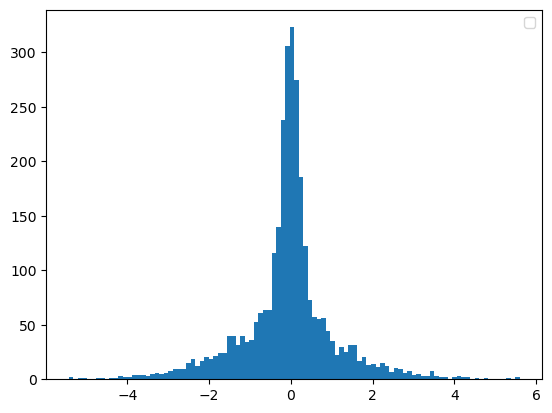

In [ ]:
import matplotlib.pyplot as plt

		# m = ' '.join([f'{k} {v:.5f} ' for k,v in metrix.items() if 'E_' in k])
plt.hist(r[0][:, :2].reshape(-1), bins=100)
plt.legend()
plt.show()

In [ ]:
data = dict(
		e=e, 
		pe=pe, 
		ke=ke, 
		grads=grads, 
		loss=loss, 
		acc=acc, 
		r=r, 
		params=state.params,
		log_psi=log_psi
	)

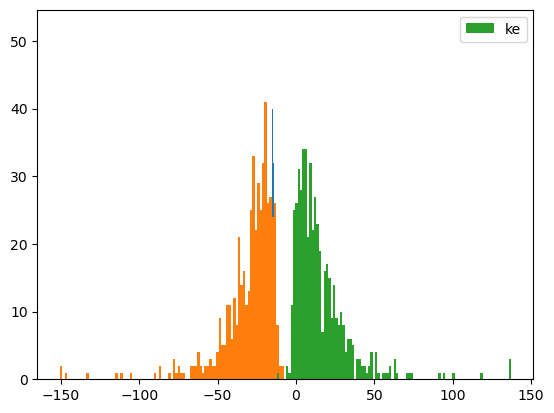

In [ ]:
import matplotlib.pyplot as plt

plt.hist(e, bins=100)
plt.hist(pe, bins=100)
plt.hist(ke, bins=100, label='ke')
plt.legend()
plt.show()

In [ ]:

def create_train_state_i(rng, r):
    model = c.partial(FermiNet)  
    params = model.init(rng, r)
    return TrainState.create(apply_fn=model.apply, params=params, tx=optax.adam(0.01))

state = create_train_state_i(rng, r[0])

deltar_i = deltar[0]
r_0 = r[0]


p_0 = (jnp.exp(state.apply_fn(state.params, r_0))**2)

for _ in jnp.arange(1, c.data.corr_len):
	rng, rng_alpha = rnd.split(rng, 2)

	r_1 = r_0 + rnd.normal(rng, r_0.shape, dtype=r_0.dtype)*deltar_i
	p_1 = jnp.exp(state.apply_fn(state.params, r_1))**2

	p_mask = (p_1/p_0) > rnd.uniform(rng_alpha, p_1.shape)
	
	p_0 = jnp.where(p_mask, p_1, p_0)
	r_0 = jnp.where(p_mask[..., None, None], r_1, r_0)	
	print(p_mask.mean())



NameError: name 'deltar' is not defined

In [ ]:
r

ShardedDeviceArray([[[[ 1.9007555e+00,  1.1410671e+00, -6.6881738e+00],
                      [-2.2503405e+01,  2.8869953e+01, -2.1502833e+00],
                      [ 4.6406641e+00,  3.9603489e+01, -3.0636536e+01],
                      [ 3.2805979e-02, -1.6124485e+01, -5.8321023e+00]],

                     [[-1.1880143e+00,  4.8265924e+00, -2.9804328e-01],
                      [-2.3986162e+01,  1.1771825e+01,  2.6481308e+01],
                      [-1.0560344e+00,  4.9753788e+01,  2.1829014e+01],
                      [ 7.9505873e-01,  3.0236721e+00, -4.5025282e+00]],

                     [[-3.0717777e+01,  2.2264914e+01,  5.9241104e+00],
                      [ 1.1509624e+00,  1.1934803e+00,  1.3152162e+00],
                      [-3.4493279e+01,  3.3944008e+01, -8.2277260e+00],
                      [ 1.1018317e+00, -1.1538062e+00, -8.3900633e+00]],

                     ...,

                     [[-3.3702240e+01,  7.8377223e+00,  2.6325283e+01],
                      [-1.01770

In [ ]:
r

ShardedDeviceArray([[[[ 1.9007555e+00,  1.1410671e+00, -6.6881738e+00],
                      [-2.2503405e+01,  2.8869953e+01, -2.1502833e+00],
                      [ 4.6406641e+00,  3.9603489e+01, -3.0636536e+01],
                      [ 3.2805979e-02, -1.6124485e+01, -5.8321023e+00]],

                     [[-1.1880143e+00,  4.8265924e+00, -2.9804328e-01],
                      [-2.3986162e+01,  1.1771825e+01,  2.6481308e+01],
                      [-1.0560344e+00,  4.9753788e+01,  2.1829014e+01],
                      [ 7.9505873e-01,  3.0236721e+00, -4.5025282e+00]],

                     [[-3.0717777e+01,  2.2264914e+01,  5.9241104e+00],
                      [ 1.1509624e+00,  1.1934803e+00,  1.3152162e+00],
                      [-3.4493279e+01,  3.3944008e+01, -8.2277260e+00],
                      [ 1.1018317e+00, -1.1538062e+00, -8.3900633e+00]],

                     ...,

                     [[-3.3702240e+01,  7.8377223e+00,  2.6325283e+01],
                      [-1.01770

In [ ]:
from jax import vmap

@partial(jax.pmap, axis_name='dev', in_axes=(0,0))
def create_train_state(rng, r):
    model = c.partial(FermiNet, with_sign=True)  
    params = model.init(rng, r)
    return TrainState.create(apply_fn=model.apply, params=params, tx=optax.adam(0.01))
    
state = create_train_state(rng, r)

@partial(vmap, in_axes=(0, None, None))
def swap_rows(r, i_0, i_1):
    return r.at[[i_0,i_1], :].set(r[[i_1,i_0], :])

@partial(pmap, in_axes=(0, 0))
def check_antisym(state, r):
    log_psi_0, sgn_0 = state.apply_fn(state.params, r)
    r_swap_u = swap_rows(r, 0, 1)
    log_psi_u, sgn_u = state.apply_fn(state.params, r_swap_u)
    log_psi_d = jnp.zeros_like(log_psi_0)
    sgn_d = jnp.zeros_like(sgn_0)
    if not c.data.n_d == 0:
        r_swap_d = swap_rows(r, c.data.n_u, c.data.n_u+1)
        log_psi_d, sgn_d = state.apply_fn(state.params, r_swap_d)
    return (log_psi_0, log_psi_u, log_psi_d), (sgn_0, sgn_u, sgn_d), (r, r_swap_u, r_swap_d)

res = check_antisym(state, r)

(log_psi, log_psi_u, log_psi_d), (sgn, sgn_u, sgn_d), (r, r_swap_u, r_swap_d) = res
for ei, ej, ek in zip(r[0,0], r_swap_u[0,0], r_swap_d[0,0]):
    print(ei, ej, ek)  # Swap Correct
for lpi, lpj, lpk in zip(log_psi[0], log_psi_u[0], log_psi_d[0]):
    print(lpi, lpj, lpk)  # Swap Correct
for lpi, lpj, lpk in zip(sgn[0], sgn_u[0], sgn_d[0]):
    print(lpi, lpj, lpk)  # Swap Correct

ValueError: pmap got inconsistent sizes for array axes to be mapped:
  * one axis had size 2: axis 0 of argument rng of type uint32[2];
  * one axis had size 1: axis 0 of argument r of type float32[1,512,4,3]

In [ ]:
from jax import vmap

def check_antisym(c, rng, r):
	n_u, n_d, = c.data.n_u, c.data.n_d
	r = r[:, :4]
	
	@partial(vmap, in_axes=(0, None, None))
	def swap_rows(r, i_0, i_1):
		return r.at[[i_0,i_1], :].set(r[[i_1,i_0], :])

	@partial(jax.pmap, axis_name='dev', in_axes=(0,0))
	def _create_train_state(rng, r):
		model = c.partial(FermiNet, with_sign=True)  
		params = model.init(rng, r)['params']
		return TrainState.create(apply_fn=model.apply, params=params, tx=c.opt.tx)
	
	state = _create_train_state(rng, r)

	@partial(pmap, in_axes=(0, 0))
	def _check_antisym(state, r):
		log_psi_0, sgn_0 = state.apply_fn(state.params, r)
		r_swap_u = swap_rows(r, 0, 1)
		log_psi_u, sgn_u = state.apply_fn(state.params, r_swap_u)
		log_psi_d = jnp.zeros_like(log_psi_0)
		sgn_d = jnp.zeros_like(sgn_0)
		if not n_d == 0:
			r_swap_d = swap_rows(r, n_u, n_u+1)
			log_psi_d, sgn_d = state.apply_fn(state.params, r_swap_d)
		return (log_psi_0, log_psi_u, log_psi_d), (sgn_0, sgn_u, sgn_d), (r, r_swap_u, r_swap_d)

	res = _check_antisym(state, r)

	(log_psi, log_psi_u, log_psi_d), (sgn, sgn_u, sgn_d), (r, r_swap_u, r_swap_d) = res
	for ei, ej, ek in zip(r[0,0], r_swap_u[0,0], r_swap_d[0,0]):
		print(ei, ej, ek)  # Swap Correct
	for lpi, lpj, lpk in zip(log_psi[0], log_psi_u[0], log_psi_d[0]):
		print(lpi, lpj, lpk)  # Swap Correct
	for lpi, lpj, lpk in zip(sgn[0], sgn_u[0], sgn_d[0]):
		print(lpi, lpj, lpk)  # Swap Correct

In [ ]:

state.params['params']



FrozenDict({
    Dense_0: {
        bias: ShardedDeviceArray([[0.01459372, 0.00997529, 0.01267799, 0.0786592 ,
                             0.04518591, 0.01598902, 0.01946411, 0.0160135 ,
                             0.0820886 , 0.066571  , 0.07754244, 0.05884545,
                             0.076667  , 0.0361336 , 0.01449547, 0.03578294,
                             0.02859007, 0.06440564, 0.09925729, 0.07102094,
                             0.07148563, 0.06547641, 0.04870448, 0.03848153,
                             0.06832297, 0.02668134, 0.02206043, 0.09556375,
                             0.04705796, 0.07842465, 0.04566721, 0.04030572]],                   dtype=float32),
        kernel: ShardedDeviceArray([[[ 2.69128174e-01, -5.06307244e-01,  1.86619103e-01,
                              -2.58631647e-01,  2.83852220e-01, -8.21515843e-02,
                              -3.84322810e-03, -3.50300491e-01, -4.67570461e-02,
                               2.10296005e-01, -4.19384778e-01,